In [1]:
import os
import munch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def mch(**kwargs):
    return munch.Munch(dict(**kwargs))

In [4]:
def configure_metadata(metadata_root):
    metadata = mch()
    metadata.image_ids = os.path.join(metadata_root, 'image_ids.txt')
    metadata.image_ids_proxy = os.path.join(metadata_root,
                                            'image_ids_proxy.txt')
    metadata.class_labels = os.path.join(metadata_root, 'class_labels.txt')
    metadata.image_sizes = os.path.join(metadata_root, 'image_sizes.txt')
    metadata.localization = os.path.join(metadata_root, 'localization.txt')
    return metadata

In [5]:
data_root = '../src/data/dataset'
metadata_root = '../src/data/metadata'
dataset_list = ['CUB', 'ILSVRC', 'SYNTHETIC']
_SPLITS = ('train', 'val', 'test')
metadata_cub_path = os.path.join(metadata_root, 'CUB')
metadata_cub_splits = {split: configure_metadata(os.path.join(metadata_cub_path, split)) for split in _SPLITS}

In [26]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from src.data_loaders import configure_metadata, get_image_ids
from PIL import Image

class WSOLDataset(Dataset):
    def __init__(self, data_root, metadata_root, transform):
        self.data_root = data_root
        self.metadata = configure_metadata(metadata_root)
        self.transform = transform
        self.image_ids = get_image_ids(self.metadata, proxy=False)
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = Image.open(os.path.join(self.data_root, image_id))
        image = image.convert('RGB')
        image = self.transform(image)
        return image, 0

    def __len__(self):
        return len(self.image_ids)

In [36]:
import torch
from tqdm import tqdm

def batch_mean_and_sd(loader, label):
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in tqdm(loader, total=len(loader), desc=label):
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
    return (mean, std)

In [35]:
from torchvision import transforms
from tqdm import tqdm

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()])

data_root = '../data/dataset'
metadata_root = '../data/metadata'
_SPLITS = ('train', 'val', 'test')

std_dev = {}
dataset = 'SYNTHETIC'
for i in tqdm(range(1, 5, 1), total=4, desc='instances'):
    for b in ('t','b'):
        for split in _SPLITS:
            spec = f'd_{str(i)}_{b}'
            metadata_root_split = os.path.join(metadata_root, dataset, spec, split)
            dataset_root = os.path.join(data_root, dataset, spec)
            image_data = WSOLDataset(dataset_root, metadata_root_split, transform)
            loader = DataLoader(image_data, batch_size=64, num_workers=0)
            mean, std = batch_mean_and_sd(loader)
            mean = mean.tolist()
            std = std.tolist()
            dataset_split = '_'.join([dataset, spec, split])
            # print(f"{dataset_split}: mean={mean}, std={std}")
            key = os.path.join('data/metadata', dataset, spec, split)
            std_dev[key] = dict(mean=mean, std=std)
print(std_dev)

instances: 100%|██████████| 4/4 [01:11<00:00, 17.77s/it]

{'data/metadata/SYNTHETIC/d_1_t/train': {'mean': [0.04273996502161026, 0.04311680421233177, 0.05591028183698654], 'std': [0.14303097128868103, 0.14330065250396729, 0.16584224998950958]}, 'data/metadata/SYNTHETIC/d_1_t/val': {'mean': [0.04410117119550705, 0.043009135872125626, 0.05730963125824928], 'std': [0.14504630863666534, 0.1432878077030182, 0.16645550727844238]}, 'data/metadata/SYNTHETIC/d_1_t/test': {'mean': [0.04006754979491234, 0.040725477039813995, 0.05305006355047226], 'std': [0.13640396296977997, 0.1406128704547882, 0.16055920720100403]}, 'data/metadata/SYNTHETIC/d_1_b/train': {'mean': [0.24238689243793488, 0.24167926609516144, 0.2536686956882477], 'std': [0.22504417598247528, 0.22468362748622894, 0.22636130452156067]}, 'data/metadata/SYNTHETIC/d_1_b/val': {'mean': [0.2390381395816803, 0.24038280546665192, 0.2509518563747406], 'std': [0.2209886610507965, 0.22130391001701355, 0.22285866737365723]}, 'data/metadata/SYNTHETIC/d_1_b/test': {'mean': [0.23923085629940033, 0.2385435

In [38]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()])

data_root = '../data/dataset'
metadata_root = '../data/metadata'
_SPLITS = ('train', 'val', 'test')
std_dev = {}
dataset = 'ILSVRC'
split='test'
dataset_split = '_'.join([dataset, split])
metadata_root_split = os.path.join(metadata_root, dataset, split)
dataset_root = os.path.join(data_root, dataset)
image_data = WSOLDataset(dataset_root, metadata_root_split, transform)
loader = DataLoader(image_data, batch_size=1024, num_workers=0)
mean, std = batch_mean_and_sd(loader, dataset_split)
mean = mean.tolist()
std = std.tolist()
# print(f"{dataset_split}: mean={mean}, std={std}")
key = os.path.join('data/metadata', dataset, split)
std_dev[key] = dict(mean=mean, std=std)
print(std_dev)

ILSVRC_test: 100%|██████████| 49/49 [03:44<00:00,  4.58s/it]

{'data/metadata/ILSVRC/test': {'mean': [0.47299250960350037, 0.4501796364784241, 0.40113767981529236], 'std': [0.2737453281879425, 0.2667834460735321, 0.2800652086734772]}}


In [ ]:
_IMAGE_MEAN_VALUE = [0.485, 0.456, 0.406]
_IMAGE_STD_VALUE = [0.229, 0.224, 0.225]


In [5]:
def get_class_labels(metadata):
    """
    image_ids.txt has the structure

    <path>,<integer_class_label>
    path/to/image1.jpg,0
    path/to/image2.jpg,1
    path/to/image3.jpg,1
    ...
    """
    class_labels = {}
    with open(metadata.class_labels) as f:
        for line in f.readlines():
            image_id, class_label_string = line.strip('\n').split(',')
            class_labels[image_id] = int(class_label_string)
    return class_labels

In [6]:
def get_bounding_boxes(metadata):
    """
    localization.txt (for bounding box) has the structure

    <path>,<x0>,<y0>,<x1>,<y1>
    path/to/image1.jpg,156,163,318,230
    path/to/image1.jpg,23,12,101,259
    path/to/image2.jpg,143,142,394,248
    path/to/image3.jpg,28,94,485,303
    ...

    One image may contain multiple boxes (multiple boxes for the same path).
    """
    boxes = {}
    with open(metadata.localization) as f:
        for line in f.readlines():
            image_id, x0s, y0s, x1s, y1s = line.strip('\n').split(',')
            x0, y0, x1, y1 = int(x0s), int(y0s), int(x1s), int(y1s)
            if image_id in boxes:
                boxes[image_id].append((x0, y0, x1, y1))
            else:
                boxes[image_id] = [(x0, y0, x1, y1)]
    return boxes

In [43]:
labels = get_class_labels(metadata_cub_splits['test'])
cub_train_labels = {'id': labels.keys(), 'label': labels.values()}

In [44]:
df = pd.DataFrame.from_dict(cub_train_labels)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5794 entries, 0 to 5793
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5794 non-null   object
 1   label   5794 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.7+ KB


In [42]:
df.groupby(df.label).count().describe()

,id
count,200.000000
mean,29.970000
std,0.171015
min,29.000000
25%,30.000000
50%,30.000000
75%,30.000000
max,30.000000


In [63]:
metadata_path = os.path.join(metadata_root, 'CUB')
metadata_splits = {split: configure_metadata(os.path.join(metadata_cub_path, split)) for split in _SPLITS}

for dataset in dataset_list:
    metadata_path = os.path.join(metadata_root, dataset)
    metadata_splits = {split: configure_metadata(os.path.join(metadata_path, split)) for split in _SPLITS}
    for split in _SPLITS:
        labels = get_class_labels(metadata_splits[split])
        boxes = get_bounding_boxes(metadata_splits[split])
        boxes_len = list(map(len, boxes.values()))
        if not boxes_len:
            boxes_len = [0] * len(labels)
        info = {'images': labels.keys(), 'labels': labels.values(), 'boxes': boxes_len}
        _min = min(boxes_len) if boxes_len else 0
        _max = max(boxes_len) if boxes_len else 0
        _max_image = list(boxes.keys())[boxes_len.index(_max)] if _max > 1 else ''
        print()
        print(f'{dataset} {split}: images = {len(labels)} classes = {len(set(labels.values()))}')
        df = pd.DataFrame.from_dict(info)
        df_grp_lbl = df.groupby(df.labels).agg({'images': 'count', 'boxes': 'max'})
        print(df_grp_lbl.describe().T)


CUB train: images = 5994 classes = 200
        count   mean       std   min   25%   50%   75%   max
images  200.0  29.97  0.171015  29.0  30.0  30.0  30.0  30.0
boxes   200.0   1.00  0.000000   1.0   1.0   1.0   1.0   1.0

CUB val: images = 1000 classes = 200
        count  mean      std  min  25%  50%  75%  max
images  200.0   5.0  0.17364  3.0  5.0  5.0  5.0  6.0
boxes   200.0   1.0  0.00000  1.0  1.0  1.0  1.0  1.0

CUB test: images = 5794 classes = 200
        count   mean       std   min   25%   50%   75%   max
images  200.0  28.97  2.920917  11.0  29.0  30.0  30.0  30.0
boxes   200.0   1.00  0.000000   1.0   1.0   1.0   1.0   1.0

ILSVRC train: images = 1281167 classes = 1000
         count      mean        std    min     25%     50%     75%     max
images  1000.0  1281.167  70.221807  732.0  1300.0  1300.0  1300.0  1300.0
boxes   1000.0     0.000   0.000000    0.0     0.0     0.0     0.0     0.0

ILSVRC val: images = 10000 classes = 1000
         count    mean        std   min 

In [102]:
split = 'test'
dataset = 'ILSVRC'
metadata_path = os.path.join(metadata_root, dataset)
metadata_splits = {split: configure_metadata(os.path.join(metadata_path, split)) for split in _SPLITS}
labels = get_class_labels(metadata_splits[split])
boxes = get_bounding_boxes(metadata_splits[split])
boxes_len = list(map(len, boxes.values()))
if not boxes_len:
    boxes_len = [0] * len(labels)
info = {'images': labels.keys(), 'labels': labels.values(), 'boxes': boxes_len}
print(f'{dataset} {split}: images = {len(labels)} classes = {len(set(labels.values()))}')
df = pd.DataFrame.from_dict(info)

ILSVRC test: images = 50000 classes = 1000


In [109]:
df.describe()

,labels,boxes
count,50000.000000,50000.000000
mean,499.500000,1.609540
std,288.677877,1.759029
min,0.000000,1.000000
25%,249.750000,1.000000
50%,499.500000,1.000000
75%,749.250000,1.000000
max,999.000000,20.000000


In [87]:
df2 = df.groupby(df.boxes).agg({'images': 'count', 'labels': 'unique'})
df2['labels'] = df2.labels.map(len)

In [93]:
print(df2)

       images  labels
boxes                
1       38285    1000
2        6128     963
3        2103     713
4        1106     514
5         668     363
6         438     278
7         290     203
8         214     148
9         150     119
10        128      93
11         97      81
12         93      78
13         66      57
14         46      44
15         50      42
16         38      30
17         26      24
18         40      35
19         22      20
20         12      12


<AxesSubplot: xlabel='boxes'>

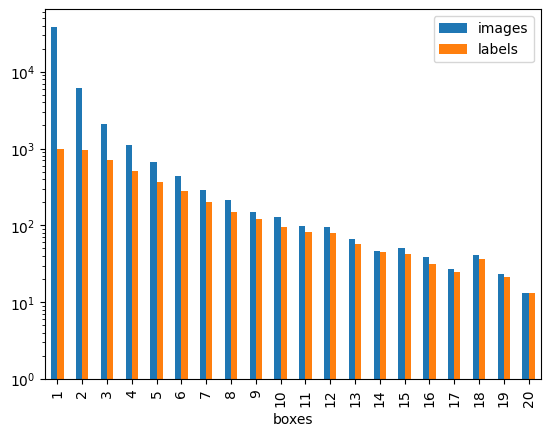

In [98]:
df2.plot.bar(log=True)

In [ ]:
z = np.random.random((6,2))
zmask = np.ones((len(e),len(g)), dtype=bool)

In [23]:
g = np.arange(2)
gmask = np.ones(len(g), dtype=bool)

In [24]:
e = np.arange(6)
emask = np.ones(len(e), dtype=bool)

In [109]:
number_of_box_list = [2,2,2]
num_threshold = len(number_of_box_list)
iou_threshold = 0.5
num_correct = {iou_threshold: np.zeros(shape=(3, z.shape[1]))}
num_correct_aggregated = {iou_threshold: np.zeros(shape=(3,))}
num_gt_boxes = 0

idx = 0
sliced_multiple_iou = []
sliced_multiple_iou_index = []
y = z.copy()
for nr_box in number_of_box_list:
    gt_iou_max_index = []
    gt_iou_max = []
    x = y[idx:idx+nr_box]
    for g_index in range(x.shape[1]):
        max_iou_index = np.unravel_index(np.argmax(x), shape=x.shape)
        gt_iou_max_index.append((max_iou_index[0] + idx, max_iou_index[1]))
        gt_iou_max.append(x[max_iou_index[0],max_iou_index[1]])
        x[max_iou_index[0], :] = 0
        x[:, max_iou_index[1]] = 0
    sliced_multiple_iou.append(np.asarray(gt_iou_max))
    sliced_multiple_iou_index.append(gt_iou_max_index)
    idx += nr_box
num_gt_boxes += len(g)

In [110]:
sliced_multiple_iou

[array([0.84180655, 0.72144019]),
 array([0.83656069, 0.181785  ]),
 array([0.77082073, 0.46672577])]

In [111]:
multi_iou_per_threshold = np.asarray(sliced_multiple_iou)
multi_iou_per_threshold

array([[0.84180655, 0.72144019],
       [0.83656069, 0.181785  ],
       [0.77082073, 0.46672577]])

In [112]:
multi_iou_max_threshold = multi_iou_per_threshold[np.average(multi_iou_per_threshold, axis=1).argmax()]
multi_iou_max_threshold

array([0.84180655, 0.72144019])

In [113]:
correct_threshold_indices = np.where(multi_iou_per_threshold > 0.5)
correct_threshold_indices

(array([0, 0, 1, 2]), array([0, 1, 0, 0]))

In [114]:
for threshold in [0.5]:
    num_correct[threshold][correct_threshold_indices] += 1
    num_correct_aggregated[threshold] = np.sum(num_correct[threshold], axis=1)

In [115]:
num_correct

{0.5: array([[1., 1.],
        [1., 0.],
        [1., 0.]])}

In [116]:
num_correct_aggregated

{0.5: array([2., 1., 1.])}

In [3]:
img = mpimg.imread('stinkbug.png')

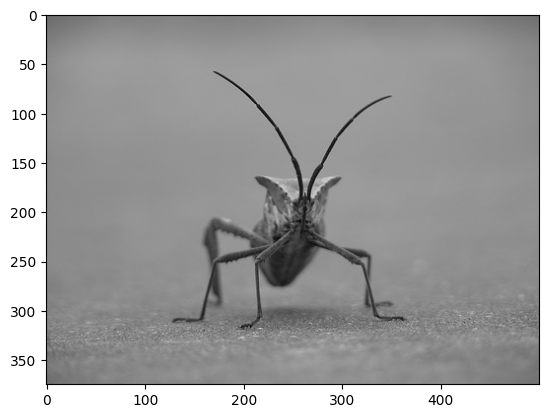

In [19]:
plt.imshow(img)

In [5]:
img = np.load('../thr_gray_heatmap.npy')

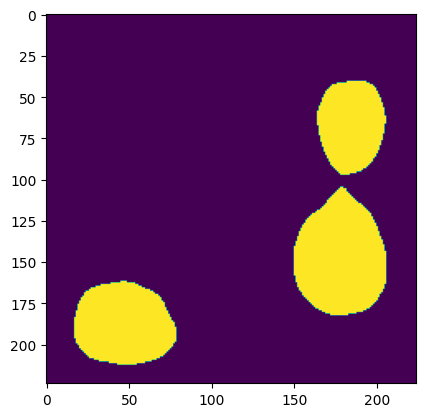

In [6]:
plt.imshow(img)

In [26]:
mpimg.imsave('stinkbug2.png', img)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

sample = np.random.randint(1, 6)

In [14]:
sample

5

In [17]:
from PIL import Image
image1 = Image.open('images/elephant.jpg')
image1.show()

FileNotFoundError: [Errno 2] No such file or directory: 'images/elephant.jpg'

In [11]:
a = np.stack([np.ones((10,10)), np.zeros((10,10))])
a.any(axis=2)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
        False]])

In [32]:
b = np.ones((10,10))
b[:3,:]=0
b[7:,:]=0
b[:,:6]=0
b[:,9:]=0

In [33]:
_x, _y = np.ma.where(b > 0)
xmin, xmax = _x[0], _x[-1]
ymin, ymax = _y[0], _y[-1]
bbox = (xmin, ymin, xmax, ymax)

In [36]:
a = np.zeros((10,10))
a[xmin:xmax+1, ymin:ymax+1] = 1
a > 0

array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False,  True,  True,  True,
        False],
       [False, False, False, False, False, False,  True,  True,  True,
        False],
       [False, False, False, False, False, False,  True,  True,  True,
        False],
       [False, False, False, False, False, False,  True,  True,  True,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]])

In [9]:
import math
print([(a,math.ceil(math.sqrt(a)), math.ceil(math.sqrt(a))**2) for a in range(1,17)])

[(1, 1, 1), (2, 2, 4), (3, 2, 4), (4, 2, 4), (5, 3, 9), (6, 3, 9), (7, 3, 9), (8, 3, 9), (9, 3, 9), (10, 4, 16), (11, 4, 16), (12, 4, 16), (13, 4, 16), (14, 4, 16), (15, 4, 16), (16, 4, 16)]


In [15]:
type(np.random.permutation(10))

numpy.ndarray

In [47]:
a = np.stack([np.zeros((2,2)), np.ones((2,2)), np.full((2,2), 2), np.full((2,2), 3)])
a

array([[[0., 0.],
        [0., 0.]],

       [[1., 1.],
        [1., 1.]],

       [[2., 2.],
        [2., 2.]],

       [[3., 3.],
        [3., 3.]]])

In [48]:
b = np.empty((4,4))
for idx in range(a.shape[0]):
    i = idx // 2
    j = idx % 2
    b[i*2:(i+1)*2,j*2:(j+1)*2] = a[idx,:2,:2]
b

array([[0., 0., 1., 1.],
       [0., 0., 1., 1.],
       [2., 2., 3., 3.],
       [2., 2., 3., 3.]])

In [49]:
c = np.empty((2,2,2,2))
for idx in range(a.shape[0]):
    i = idx // 2
    j = idx % 2
    c[i,j] = a[idx]
np.concatenate(np.concatenate(c, axis=1), axis=1)

array([[0., 0., 1., 1.],
       [0., 0., 1., 1.],
       [2., 2., 3., 3.],
       [2., 2., 3., 3.]])

In [50]:
np.concatenate(c, axis=1)

array([[[0., 0.],
        [0., 0.],
        [2., 2.],
        [2., 2.]],

       [[1., 1.],
        [1., 1.],
        [3., 3.],
        [3., 3.]]])

In [51]:
a.reshape((2,2,2,2))

array([[[[0., 0.],
         [0., 0.]],

        [[1., 1.],
         [1., 1.]]],


       [[[2., 2.],
         [2., 2.]],

        [[3., 3.],
         [3., 3.]]]])

In [56]:
np.concatenate(np.concatenate(a.reshape((2,2,2,2)), axis=1), axis=1)

array([[0., 0., 1., 1.],
       [0., 0., 1., 1.],
       [2., 2., 3., 3.],
       [2., 2., 3., 3.]])

In [2]:
import cv2

In [5]:
np.eye(6)

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [23]:
im_small = cv2.resize(np.eye(6), (3,3), interpolation=cv2.INTER_LINEAR)

In [22]:
im_small

array([[0.5, 0. , 0. ],
       [0. , 0.5, 0. ],
       [0. , 0. , 0.5]])

In [20]:
from PIL import Image

im = Image.fromarray(np.eye(6))
np.array(im.resize((3,3)))

array([[ 0.44769877,  0.06951676, -0.02079795],
       [ 0.06951676,  0.3858458 ,  0.06951676],
       [-0.02079795,  0.06951676,  0.44769877]], dtype=float32)

In [3]:
import cv2

In [4]:
img_path = '../src/dataset/SYNTHETIC/o_1_t/test/SYNTHETIC_o_1_t_test_1.png'
img = cv2.imread(img_path)

In [6]:
img.shape

(512, 512, 3)

In [7]:
cv2.imwrite('test.png', img)

True

In [23]:
(1,2,3,4)[2:][::-1]

(4, 3)

In [24]:
gt_bbox_list = [(148,125,260,266)] # row0,col0,row1,col1 format (matrix notation)
thickness = 2  # Pixels
image = cv2.imread('test.png')
for bbox in gt_bbox_list:
    start, end = bbox[:2][::-1], bbox[2:][::-1] # convert matrix to xy notation for cv2
    color = (0, 255, 0) # Green color in BGR
    image = cv2.rectangle(image, start, end, color, thickness)
# for bbox in est_bbox_list:
#     start, end = bbox[:2], bbox[2:]
#     color = (0, 0, 255) # Red color in BGR
#     image = cv2.rectangle(image, start, end, color, thickness)
cv2.imwrite('test_bbox.png', image)

True

In [5]:
import cv2

In [6]:
img_path = '../data/dataset/ILSVRC/val/ILSVRC2012_val_00000001.JPEG'
img = cv2.imread(img_path)

In [7]:
img.shape

(375, 500, 3)

In [11]:
cv2.imwrite('test2.png', img)

True

In [12]:
gt_bbox_list = [(111,108,441,193)] # x0,y0,x1,y1 format (xy axis notation)
thickness = 2  # Pixels
image = cv2.imread('test2.png')
for bbox in gt_bbox_list:
    start, end = bbox[:2], bbox[2:]
    color = (0, 255, 0) # Green color in BGR
    image = cv2.rectangle(image, start, end, color, thickness)
# for bbox in est_bbox_list:
cv2.imwrite('test2_bbox.png', image)

True

In [2]:
path = '../src/dataset/SYNTHETIC/o_1_t/test/SYNTHETIC_o_1_t_test_1.png'
img = mpimg.imread(path)
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: '../src/dataset/SYNTHETIC/o_1_t/test/SYNTHETIC_o_1_t_test_1.png'

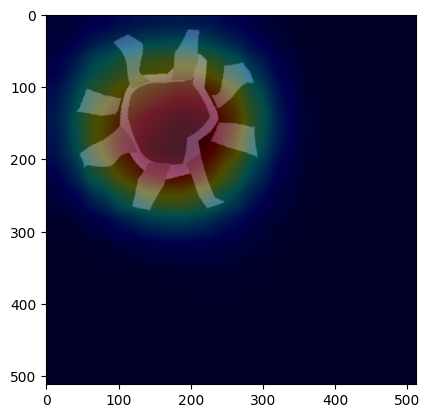

In [29]:
path = '../src/train_log/vgg16_cam_synthetic_o1t/scoremaps/test/SYNTHETIC_o_1_t_test_1.png'
img = mpimg.imread(path)
plt.imshow(img)

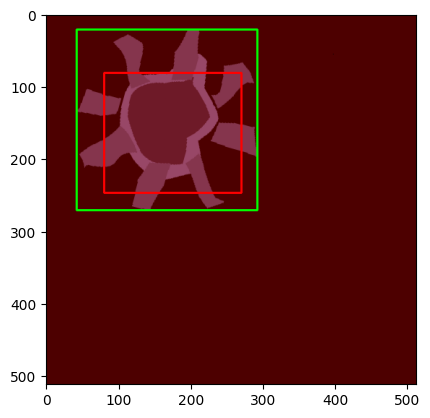

In [30]:
path = '../src/train_log/vgg16_cam_synthetic_o1t/scoremaps/test/SYNTHETIC_o_1_t_test_1_ann.png'
img = mpimg.imread(path)
plt.imshow(img)

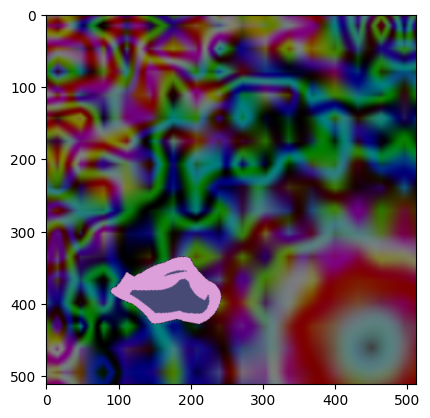

In [27]:
path = '../src/dataset/SYNTHETIC/o_1_b/test/SYNTHETIC_o_1_b_test_1.png'
img = mpimg.imread(path)
plt.imshow(img)

In [34]:
import pandas as pd
import json

In [52]:
path = '../src/train_log/vgg16_cam_synthetic_o1t/reports/train'
epochs = range(1,21,1)
epoch_metrics = []
for epoch in epochs:
    with open(f'{path}/{epoch}', 'r') as f:
        epoch_metric = json.load(f)
        epoch_metrics.append(epoch_metric)
df = pd.DataFrame(epoch_metrics)

In [53]:
path = '../src/train_log/vgg16_cam_synthetic_o1t/reports/val'
epochs = range(1,21,1)
epoch_metrics = []
for epoch in epochs:
    with open(f'{path}/{epoch}', 'r') as f:
        epoch_metric = json.load(f)
        epoch_metrics.append(epoch_metric)
df2 = pd.DataFrame(epoch_metrics)

<AxesSubplot: xlabel='step'>

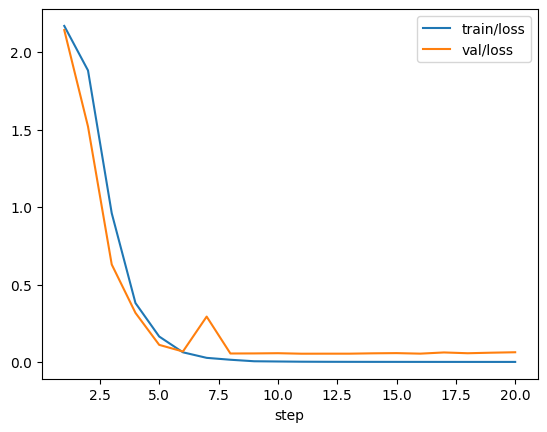

In [58]:
df.loc[:, 'val/loss'] = df2['val/loss']
df.plot('step', ['train/loss', 'val/loss'])

<AxesSubplot: xlabel='step'>

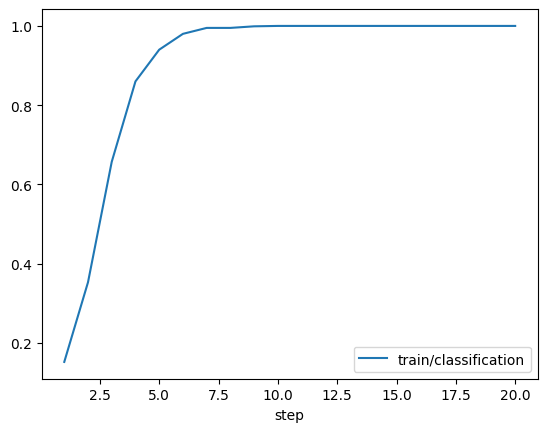

In [46]:
df.plot('step', 'train/classification')

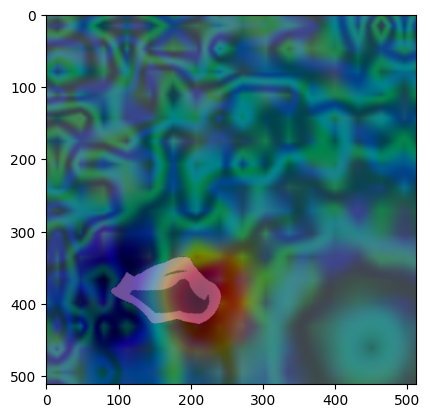

In [31]:
path = '../src/train_log/vgg16_cam_synthetic_o1b/scoremaps/test/SYNTHETIC_o_1_b_test_1.png'
img = mpimg.imread(path)
plt.imshow(img)

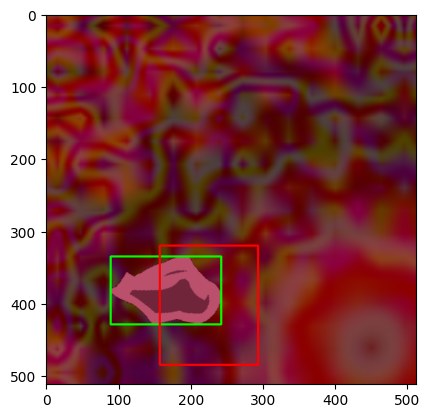

In [32]:
path = '../src/train_log/vgg16_cam_synthetic_o1b/scoremaps/test/SYNTHETIC_o_1_b_test_1_ann.png'
img = mpimg.imread(path)
plt.imshow(img)

In [62]:
path = '../src/train_log/vgg16_cam_synthetic_o1b/reports/train'
epochs = range(1,21,1)
epoch_metrics = []
for epoch in epochs:
    with open(f'{path}/{epoch}', 'r') as f:
        epoch_metric = json.load(f)
        epoch_metrics.append(epoch_metric)
df = pd.DataFrame(epoch_metrics)
path = '../src/train_log/vgg16_cam_synthetic_o1b/reports/val'
epochs = range(1,21,1)
epoch_metrics = []
for epoch in epochs:
    with open(f'{path}/{epoch}', 'r') as f:
        epoch_metric = json.load(f)
        epoch_metrics.append(epoch_metric)
df2 = pd.DataFrame(epoch_metrics)

<AxesSubplot: xlabel='step'>

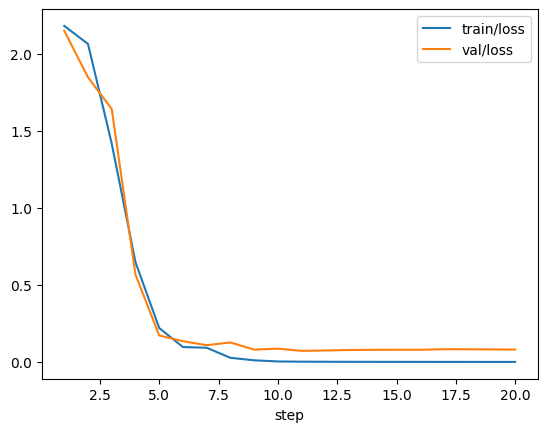

In [63]:
df.loc[:, 'val/loss'] = df2['val/loss']
df.plot('step', ['train/loss', 'val/loss'])

<AxesSubplot: xlabel='step'>

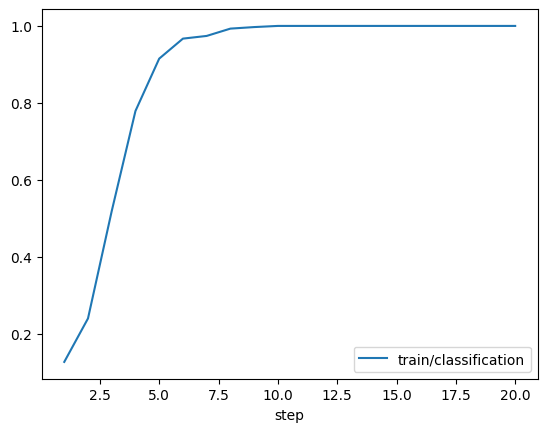

In [49]:
df.plot('step', 'train/classification')

In [1]:
import torch
checkpoint_path = '../src/train_log/vgg16_cam_synthetic_o1t/best_checkpoint.pt'
checkpoint = torch.load(checkpoint_path)

In [28]:
from typing import Mapping, Any, List
import numpy as np

class PerformanceMeter(object):
    def __init__(self, split, higher_is_better=True):
        self.best_function = max if higher_is_better else min
        self.current_value = None
        self.best_value = None
        self.best_epoch = None
        self.value_per_epoch = [] \
            if split == 'val' else [-np.inf if higher_is_better else np.inf]

    def update(self, new_value):
        self.value_per_epoch.append(new_value)
        self.current_value = self.value_per_epoch[-1]
        self.best_value = self.best_function(self.value_per_epoch)
        self.best_epoch = self.value_per_epoch.index(self.best_value)

    def state_dict(self):
        fetched_keys = ['value_per_epoch']
        return { key: getattr(self, key) for key in fetched_keys }

    def load_state_dict(self, state_dict: Mapping[str, Any], strict: bool = True):
        if not isinstance(state_dict, Mapping):
            raise TypeError("Expected state_dict to be dict-like, got {}.".format(type(state_dict)))
        error_msgs: List[str] = []
        if strict:
            missing_keys = []
            unexpected_keys = []
            expected_keys = ['value_per_epoch']
            for key in expected_keys:
                if key not in state_dict:
                    missing_keys.append(key)
            for key in state_dict:
                if key not in expected_keys:
                    unexpected_keys.append(key)
            if len(unexpected_keys) > 0:
                error_msgs.insert(
                    0, 'Unexpected key(s) in state_dict: {}. '.format(
                        ', '.join('"{}"'.format(k) for k in unexpected_keys)))
            if len(missing_keys) > 0:
                error_msgs.insert(
                    0, 'Missing key(s) in state_dict: {}. '.format(
                        ', '.join('"{}"'.format(k) for k in missing_keys)))
        if len(error_msgs) > 0:
            raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
                               self.__class__.__name__, "\n\t".join(error_msgs)))
        for key, val in state_dict.items():
            setattr(self, key, val)
        if len(self.value_per_epoch) > 0:
            self.current_value = self.value_per_epoch[-1]
            self.best_value = self.best_function(self.value_per_epoch)
            self.best_epoch = self.value_per_epoch.index(self.best_value)

In [29]:
performance_meters = {
    split: {
            metric: PerformanceMeter(split,
                                     higher_is_better=False
                                     if metric == 'loss' else True)
        for metric in ['loss','classification','MaxBoxAccV3','PxAP']
    }
    for split in ['train','val','test']
}

In [30]:
performance_meters_state_dict = {
    split: {
            metric: performance_meters[split][metric].state_dict()
        for metric in ['loss','classification','MaxBoxAccV3','PxAP']
    }
    for split in ['train','val','test']
}

In [31]:
performance_meters_state_dict

{'train': {'loss': {'value_per_epoch': [inf]},
  'classification': {'value_per_epoch': [-inf]},
  'MaxBoxAccV3': {'value_per_epoch': [-inf]},
  'PxAP': {'value_per_epoch': [-inf]}},
 'val': {'loss': {'value_per_epoch': []},
  'classification': {'value_per_epoch': []},
  'MaxBoxAccV3': {'value_per_epoch': []},
  'PxAP': {'value_per_epoch': []}},
 'test': {'loss': {'value_per_epoch': [inf]},
  'classification': {'value_per_epoch': [-inf]},
  'MaxBoxAccV3': {'value_per_epoch': [-inf]},
  'PxAP': {'value_per_epoch': [-inf]}}}

In [32]:
import torch

torch.save({'epoch':0,
            'performance_meters':performance_meters_state_dict}, 'test.pt')

In [33]:
checkpoint = torch.load('test.pt')

In [34]:
checkpoint

{'epoch': 0,
 'performance_meters': {'train': {'loss': {'value_per_epoch': [inf]},
   'classification': {'value_per_epoch': [-inf]},
   'MaxBoxAccV3': {'value_per_epoch': [-inf]},
   'PxAP': {'value_per_epoch': [-inf]}},
  'val': {'loss': {'value_per_epoch': []},
   'classification': {'value_per_epoch': []},
   'MaxBoxAccV3': {'value_per_epoch': []},
   'PxAP': {'value_per_epoch': []}},
  'test': {'loss': {'value_per_epoch': [inf]},
   'classification': {'value_per_epoch': [-inf]},
   'MaxBoxAccV3': {'value_per_epoch': [-inf]},
   'PxAP': {'value_per_epoch': [-inf]}}}}

In [35]:
for split, metrics in checkpoint['performance_meters'].items():
    for metric, meters in metrics.items():
        performance_meters[split][metric].load_state_dict(meters)

In [40]:
len(range(6,10,1))

4

In [1]:
import mlflow

# Create nested runs
experiment_id = mlflow.create_experiment("experiment1")
with mlflow.start_run(
    run_name="PARENT_RUN",
    experiment_id=experiment_id,
    tags={"version": "v1", "priority": "P1"},
    description="parent",
) as parent_run:
    mlflow.log_param("parent", "yes")
    with mlflow.start_run(
        run_name="CHILD_RUN",
        experiment_id=experiment_id,
        description="child",
        nested=True,
    ) as child_run:
        mlflow.log_param("child", "yes")

print("parent run:")

print("run_id: {}".format(parent_run.info.run_id))
print("description: {}".format(parent_run.data.tags.get("mlflow.note.content")))
print("version tag value: {}".format(parent_run.data.tags.get("version")))
print("priority tag value: {}".format(parent_run.data.tags.get("priority")))
print("--")

# Search all child runs with a parent id
query = "tags.mlflow.parentRunId = '{}'".format(parent_run.info.run_id)
results = mlflow.search_runs(experiment_ids=[experiment_id], filter_string=query)
print("child runs:")
print(results[["run_id", "params.child", "tags.mlflow.runName"]])

parent run:
run_id: b38a49ccc09444f6b104c3d6138d1455
description: parent
version tag value: v1
priority tag value: P1
--
child runs:
                             run_id params.child tags.mlflow.runName
0  a05f20191bc74ad4a595de70284069c4          yes           CHILD_RUN


In [6]:
import mlflow

# Create nested runs
experiment = mlflow.get_experiment_by_name("experiment2")
experiment_id = experiment.experiment_id
with mlflow.start_run(
    run_name="PARENT_RUN",
    experiment_id=experiment_id,
    tags={"version": "v1", "priority": "P1"},
    description="parent",
) as parent_run:
    mlflow.log_param("parent", "yes")

print("parent run:")
print("run_id: {}".format(parent_run.info.run_id))
print("description: {}".format(parent_run.data.tags.get("mlflow.note.content")))
print("version tag value: {}".format(parent_run.data.tags.get("version")))
print("priority tag value: {}".format(parent_run.data.tags.get("priority")))
print("--")

parent run:
run_id: 8b7082d2eccd43609f1b3b6a0418a5b2
description: parent
version tag value: v1
priority tag value: P1
--


In [13]:
cam_thresholds = np.linspace(0, 1, num=int(1/0.01), endpoint=False)
box_accuracies = (np.sin(np.pi * cam_thresholds) * 0.65)

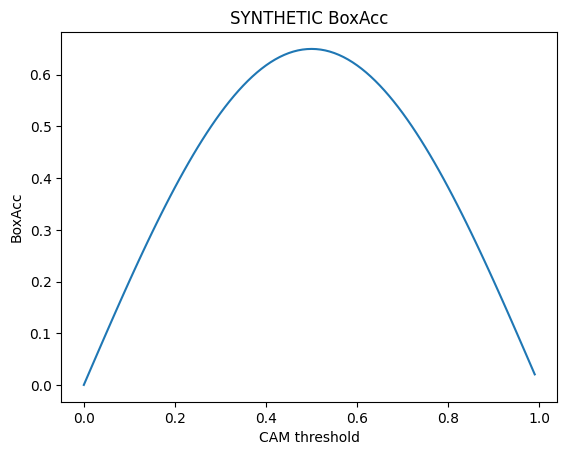

In [16]:
import mlflow

fig, ax = plt.subplots()
ax.plot(cam_thresholds, box_accuracies)
plt.title('SYNTHETIC BoxAcc')
plt.xlabel('CAM threshold')
plt.ylabel('BoxAcc')
plt.axis('tight')
with mlflow.start_run():
    mlflow.log_figure(fig, "figure.png")


In [1]:
from torch.utils.model_zoo import load_url

vgg16_path = 'https://download.pytorch.org/models/vgg16-397923af.pth'
state_dict = load_url(vgg16_path, progress=True)

In [3]:
list(state_dict)

['features.0.weight',
 'features.0.bias',
 'features.2.weight',
 'features.2.bias',
 'features.5.weight',
 'features.5.bias',
 'features.7.weight',
 'features.7.bias',
 'features.10.weight',
 'features.10.bias',
 'features.12.weight',
 'features.12.bias',
 'features.14.weight',
 'features.14.bias',
 'features.17.weight',
 'features.17.bias',
 'features.19.weight',
 'features.19.bias',
 'features.21.weight',
 'features.21.bias',
 'features.24.weight',
 'features.24.bias',
 'features.26.weight',
 'features.26.bias',
 'features.28.weight',
 'features.28.bias',
 'classifier.0.weight',
 'classifier.0.bias',
 'classifier.3.weight',
 'classifier.3.bias',
 'classifier.6.weight',
 'classifier.6.bias']

In [4]:
import torch
torch.__version__

'1.13.0'

In [2]:
from torchvision.models import vgg16, VGG16_Weights

weights = VGG16_Weights.IMAGENET1K_V1
model = vgg16(weights=weights, progress=True, num_classes=1000)

In [6]:
model.features[-2]

ReLU(inplace=True)

In [1]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights, progress=True, num_classes=1000)

In [2]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
model

ResNetCam(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [7]:
import src.wsol.resnet as resnet

model = resnet.resnet50(
    architecture_type='cam', pretrained=True, pretrained_path=None, dataset_name='SYNTHETIC', num_classes=9)

In [28]:
class A:
    def __init__(self, x, y, **kwargs):
        self.x = x
        self.y = y

In [29]:
A(**{'x': 1, 'y':2})

['d1t', 'd1b', 'd2t', 'd2b', 'd3t', 'd3b', 'd4t', 'd4b']

In [1]:
import torch
import os

load_prefix = 'vgg16_gap_cam_imagenet'
load_models = [load_prefix]
# variants = [ f'd{i}{j}' for i in range(1,5) for j in 'tb' ]
# load_models = [f'{load_prefix}_{v}' for v in variants]
save_prefix = 'vgg16_gap_cam_imagenet'
save_models = [save_prefix]
# save_models = [f'{save_prefix}_{v}' for v in variants]
for load_model, save_model in zip(load_models, save_models):
    load_path = os.path.join('..', 'train_log', load_model, 'last_checkpoint.pt')
    state_dict = torch.load(load_path, map_location=torch.device('cpu'))['model_state_dict']
    save_path = os.path.join('..', 'models', f'{save_model}.pt')
    torch.save(state_dict, save_path)

In [2]:
import torch
load_model = '../train_log/minmaxcam_syn_d2b/last_checkpoint.pt'
save_model = '../models/minmaxcam_syn d2b.pt'
state_dict = torch.load(load_model, map_location=torch.device('cpu'))['model_state_dict']
torch.save(state_dict, save_model)

In [1]:
from resource import *
import time

# a non CPU-bound task
time.sleep(3)
print(getrusage(RUSAGE_SELF))

# a CPU-bound task
for i in range(10 ** 8):
   _ = 1 + 1
print(getrusage(RUSAGE_SELF))

resource.struct_rusage(ru_utime=0.269905, ru_stime=0.06901499999999999, ru_maxrss=66551808, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=8124, ru_majflt=13, ru_nswap=0, ru_inblock=0, ru_oublock=0, ru_msgsnd=141, ru_msgrcv=136, ru_nsignals=0, ru_nvcsw=66, ru_nivcsw=637)
resource.struct_rusage(ru_utime=2.879664, ru_stime=0.076191, ru_maxrss=66584576, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=8128, ru_majflt=13, ru_nswap=0, ru_inblock=0, ru_oublock=0, ru_msgsnd=147, ru_msgrcv=140, ru_nsignals=0, ru_nvcsw=68, ru_nivcsw=913)


In [8]:
import torch

a = torch.randn(1, 4, 4)
a.view(1, -1)

tensor([[ 1.0803, -0.3308,  0.1863, -0.0790, -0.6919,  1.1206,  0.1639,  1.1351,
          1.3623, -1.1669,  0.8374, -0.2673,  1.2208, -0.3343,  0.8692, -0.2995]])

In [9]:
a.view(1, -1).max(dim=-1)

torch.return_types.max(
values=tensor([1.3623]),
indices=tensor([8]))

# TarDataSet

In [1]:
from torch.utils.data import Dataset
from torchvision import transforms
from src.data_loaders import configure_metadata, get_image_ids, get_class_labels
from PIL import Image
import tarfile
import lmdb
import os
import io
import cv2
import torch
import pickle

class ImagenetTrainTarDataset(Dataset):
    def __init__(self, tar_path, metadata_root, transform):
        self.tar_path = tar_path
        self.tar_file = tarfile.open(name=path, mode='r')
        self.metadata = configure_metadata(metadata_root)
        self.image_ids = get_image_ids(self.metadata, proxy=False)
        self.image_labels = get_class_labels(self.metadata)
        self.transform = transform

    def __getitem__(self, idx):
        # example image_id: train/n01440764/n01440764_10026.JPEG
        image_id = self.image_ids[idx]
        image_label = self.image_labels[image_id]
        id_parts = image_id.split('/')
        class_id = id_parts[1]
        image_filename = id_parts[2]
        # extract <class_id>.tar file
        class_tarfname = f'{class_id}.tar'
        tar = tarfile.open(fileobj=self.tar_file.extractfile(class_tarfname))
        buf = tar.extractfile(image_filename).read()
        tar.close()
        with io.BytesIO(buf) as bio:
            image = Image.open(bio).convert('RGB')
        image = self.transform(image)
        return image, image_label, image_id

    def __len__(self):
        return len(self.image_ids)


class WSOLImageLabelLmdbDataset(Dataset):
    environments = dict()
    def __init__(self, lmdb_path, metadata_root, transform):
        self.lmdb_path = lmdb_path
        if lmdb_path not in self.environments:
            self.environments[lmdb_path] = lmdb.open(lmdb_path, subdir=os.path.isdir(lmdb_path),
                                                     readonly=True, lock=False,
                                                     readahead=False, meminit=False)
        with self.environments[lmdb_path].begin(write=False) as txn:
            self.length = pickle.loads(txn.get(b'__len__'))
        self.metadata = configure_metadata(metadata_root)
        self.image_ids = get_image_ids(self.metadata, proxy=False)
        self.image_labels = get_class_labels(self.metadata)
        self.transform = transform

    def __getitem__(self, idx):
        image, target = None, None
        # example image_id: train/n01440764/n01440764_10026.JPEG
        image_id = self.image_ids[idx]
        image_label = self.image_labels[image_id]
        env = self.environments[self.lmdb_path]
        with env.begin(write=False) as txn:
            key = u'{}'.format(image_id).encode('ascii')
            byteflow = txn.get(key)
        image_buffer = pickle.loads(byteflow)
        with io.BytesIO(image_buffer) as bio:
            image = Image.open(bio).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, image_label, image_id

    def __len__(self):
        return self.length


_IMAGE_MEAN_VALUE = [0.485, 0.456, 0.406]
_IMAGE_STD_VALUE = [0.229, 0.224, 0.225]
resize_size = 256
crop_size = 224
tar_path = '../data/dataset/ILSVRC/ILSVRC2012_img_train.tar'
lmdb_path = '../lmdb_train.lmdb'
metadata_root = '../data/metadata/ILSVRC/train'

transform = transforms.Compose([
            transforms.Resize((resize_size, resize_size)),
            transforms.RandomCrop(crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()])
            # transforms.Normalize(_IMAGE_MEAN_VALUE, _IMAGE_STD_VALUE)])
dataset = WSOLImageLabelLmdbDataset(lmdb_path, metadata_root, transform)
img, label, id = dataset[4]
print(img.shape)
print(label)
print(id)

img_hwc = torch.permute(img, (1, 2, 0)) # CHW -> HWC
img_np = img_hwc.detach().cpu().numpy()
img_np = (img_np * 255).astype('uint8')
img_np = cv2.cvtColor(img_np, cv2.COLOR_RGBA2BGRA)
cv2.imwrite('test.png', img_np)

TypeError: a bytes-like object is required, not 'NoneType'

In [47]:
from torchvision import transforms

# _IMAGE_MEAN_VALUE = [0.485, 0.456, 0.406]
# _IMAGE_STD_VALUE = [0.229, 0.224, 0.225]
resize_size = 256
crop_size = 224

transform = transforms.Compose([
            transforms.Resize((resize_size, resize_size)),
            transforms.RandomCrop(crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()])
            # transforms.Normalize(_IMAGE_MEAN_VALUE, _IMAGE_STD_VALUE)])
dataset = ImagenetTrainTarDataset(path, metadata_root, transform)
img, label, id = dataset[4]
print(img.shape)
print(label)
print(id)

torch.Size([3, 224, 224])
0
train/n01440764/n01440764_10042.JPEG


In [48]:
import cv2
import numpy as np
import torch

img_hwc = torch.permute(img, (1, 2, 0)) # CHW -> HWC
img_np = img_hwc.detach().cpu().numpy()
img_np = (img_np * 255).astype('uint8')
img_np = cv2.cvtColor(img_np, cv2.COLOR_RGBA2BGRA)
cv2.imwrite('test.png', img_np)


True

In [42]:
im = Image.open('SYNTHETIC_d_2_b_test_103.png')

In [43]:
print(im.format, im.size, im.mode)

PNG (512, 512) RGBA


# MinMaxCAM performance

In [98]:
from src.data_loaders import get_data_loader
import os
import munch

data_root = 'data/dataset'
metadata_root = 'data/metadata'
split = 'train'
batch_size=256
workers=0
resize_size=256
crop_size = 224
proxy_training_set = False
num_val_sample_per_class = 0
batch_set_size = 12
class_set_size = 5
train_augment = True
dataset_name = 'ILSVRC'
metadata_root = os.path.join(metadata_root, dataset_name)
train = val = test = os.path.join(data_root, dataset_name)
data_paths = munch.Munch(dict(train=train, val=val, test=test))

loaders = get_data_loader(data_paths, metadata_root, batch_size, workers,
                    resize_size, crop_size, proxy_training_set,
                    num_val_sample_per_class=num_val_sample_per_class,
                    batch_set_size=batch_set_size, class_set_size=class_set_size,
                    train_augment=train_augment, dataset_name=dataset_name)

In [99]:
from src.data_loaders import configure_metadata, get_image_ids, get_class_labels

train_loader = loaders['train']
metadata = configure_metadata(os.path.join(metadata_root, split))
image_ids = get_image_ids(metadata, proxy=False)
image_labels = get_class_labels(metadata)

In [102]:
from PIL import Image
import io

idx = 0
image_id = image_ids[idx]
image_label = image_labels[image_id]

# lmdb_path = 'data/dataset/ILSVRC/lmdb_train.lmdb'
lmdb_path = 'lmdb_train.lmdb'
env = lmdb.open(lmdb_path, subdir=os.path.isdir(lmdb_path), readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    length = pickle.loads(txn.get(b'__len__'))
    print(length)
    key = u'{}'.format(idx).encode('ascii')
    print(key)
    byteflow = txn.get(key)
image_buffer = pickle.loads(byteflow)
with io.BytesIO(image_buffer) as bio:
    image = Image.open(bio).convert('RGB')

1281167
b'0'


In [103]:
from torch.utils.data import Dataset

class WSOLImageLabelLmdbDataset(Dataset):
    environments = dict()
    def __init__(self, lmdb_path, metadata_root, transform, normalize):
        self.lmdb_path = lmdb_path
        if lmdb_path not in self.environments:
            self.environments[lmdb_path] = lmdb.open(lmdb_path, subdir=os.path.isdir(lmdb_path),
                                                     readonly=True, lock=False,
                                                     readahead=False, meminit=False)
        with self.environments[lmdb_path].begin(write=False) as txn:
            self.length = pickle.loads(txn.get(b'__len__'))
        self.metadata = configure_metadata(metadata_root)
        self.image_ids = get_image_ids(self.metadata, proxy=False)
        self.image_labels = get_class_labels(self.metadata)
        self.transform = transform
        self.normalize = normalize

    def __getitem__(self, idx):
        image, target = None, None
        # example image_id: train/n01440764/n01440764_10026.JPEG
        image_id = self.image_ids[idx]
        image_label = self.image_labels[image_id]
        env = self.environments[self.lmdb_path]
        with env.begin(write=False) as txn:
            key = u'{}'.format(idx).encode('ascii')
            byteflow = txn.get(key)
        image_buffer = pickle.loads(byteflow)
        with io.BytesIO(image_buffer) as bio:
            image = Image.open(bio).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        if self.normalize is not None:
            image = self.normalize(image)
        return image, image_label, image_id

    def __len__(self):
        return self.length

In [104]:
from src.data_loaders import _CAT_IMAGE_MEAN_STD
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((resize_size, resize_size)),
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
metadata_root_split = os.path.join(metadata_root, split)
mean_std = _CAT_IMAGE_MEAN_STD[metadata_root_split]
mean, std = mean_std['mean'], mean_std['std']
normalize = transforms.Normalize(mean, std)

dataset = WSOLImageLabelLmdbDataset(
    lmdb_path=lmdb_path,
    metadata_root=os.path.join(metadata_root, split),
    transform=transform, normalize=normalize
)

In [105]:
%%time

from tqdm import tqdm

count = 0
for index, (images, targets, image_id) in enumerate(tqdm(dataset, total=len(dataset), desc='imagenet')):
    count += 1

print(f'Iterated {count} images')

imagenet:  40%|████      | 517031/1281167 [32:17<47:43, 266.86it/s]  
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [68]:
import lmdb
import pickle

# lmdb_path = 'data/dataset/ILSVRC/lmdb_train.lmdb'
lmdb_path = 'lmdb_train.lmdb'
env = lmdb.open(lmdb_path, subdir=os.path.isdir(lmdb_path), readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    length = pickle.loads(txn.get(b'__len__'))

In [69]:
length

10